In [1]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif
!pip install biosppy
!pip install heartpy

You should consider upgrading via the '/home/francescog/Scaricati/AML_Pr_2/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/francescog/Scaricati/AML_Pr_2/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import neurokit2 as nk
import heartpy as hp
from statistics import mean
import functions
from multiprocessing import Pool
from datetime import time
from pandarallel import pandarallel
import functions
import scipy
import math
import pywt
import operator
from functions import *
import itertools

In [3]:
folder = ""
raw = folder + "raw_data/"
raw_dataset_x = pd.read_csv(raw + 'X_train.csv',index_col=['id'])


In [4]:
raw_dataset_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5117 entries, 0 to 5116
Columns: 17807 entries, x0 to x17806
dtypes: float64(15348), int64(2459)
memory usage: 695.2 MB


In [5]:
raw_dataset_y = pd.read_csv(raw + 'y_train.csv',index_col=['id'])
raw_dataset_y.head()

,y
id,
0,0
1,0
2,0
3,1
4,2


In [6]:
just_scoring = True
if just_scoring:
    preprocessed = folder + "preprocessed_data/"
    x_train, x_test, y_train, y_test = train_test_split(raw_dataset_x, raw_dataset_y, test_size=0.2, random_state=100)
else:
    preprocessed = folder + "ready_data/"
    x_train = pd.read_csv(raw + 'X_train.csv', index_col=['id'])
    x_test = pd.read_csv(raw + 'X_test.csv', index_col=['id'])
    y_train = pd.read_csv(raw + 'y_train.csv', index_col=['id'])
    y_test = pd.DataFrame({'A': []})

In [7]:
labels = pd.read_csv('raw_data/y_train.csv', index_col='id')

In [8]:
# Retrieve one sample recording per class for plotting
labels_array = labels['y'].to_numpy()
num_classes = 4
sample_signal_ids = []
for class_id in range(num_classes):
    sample_signal_ids.append(int(np.argwhere(labels_array == class_id)[0]))
    
# Print indices of the sample signals
sample_signal_ids

[0, 3, 4, 30]

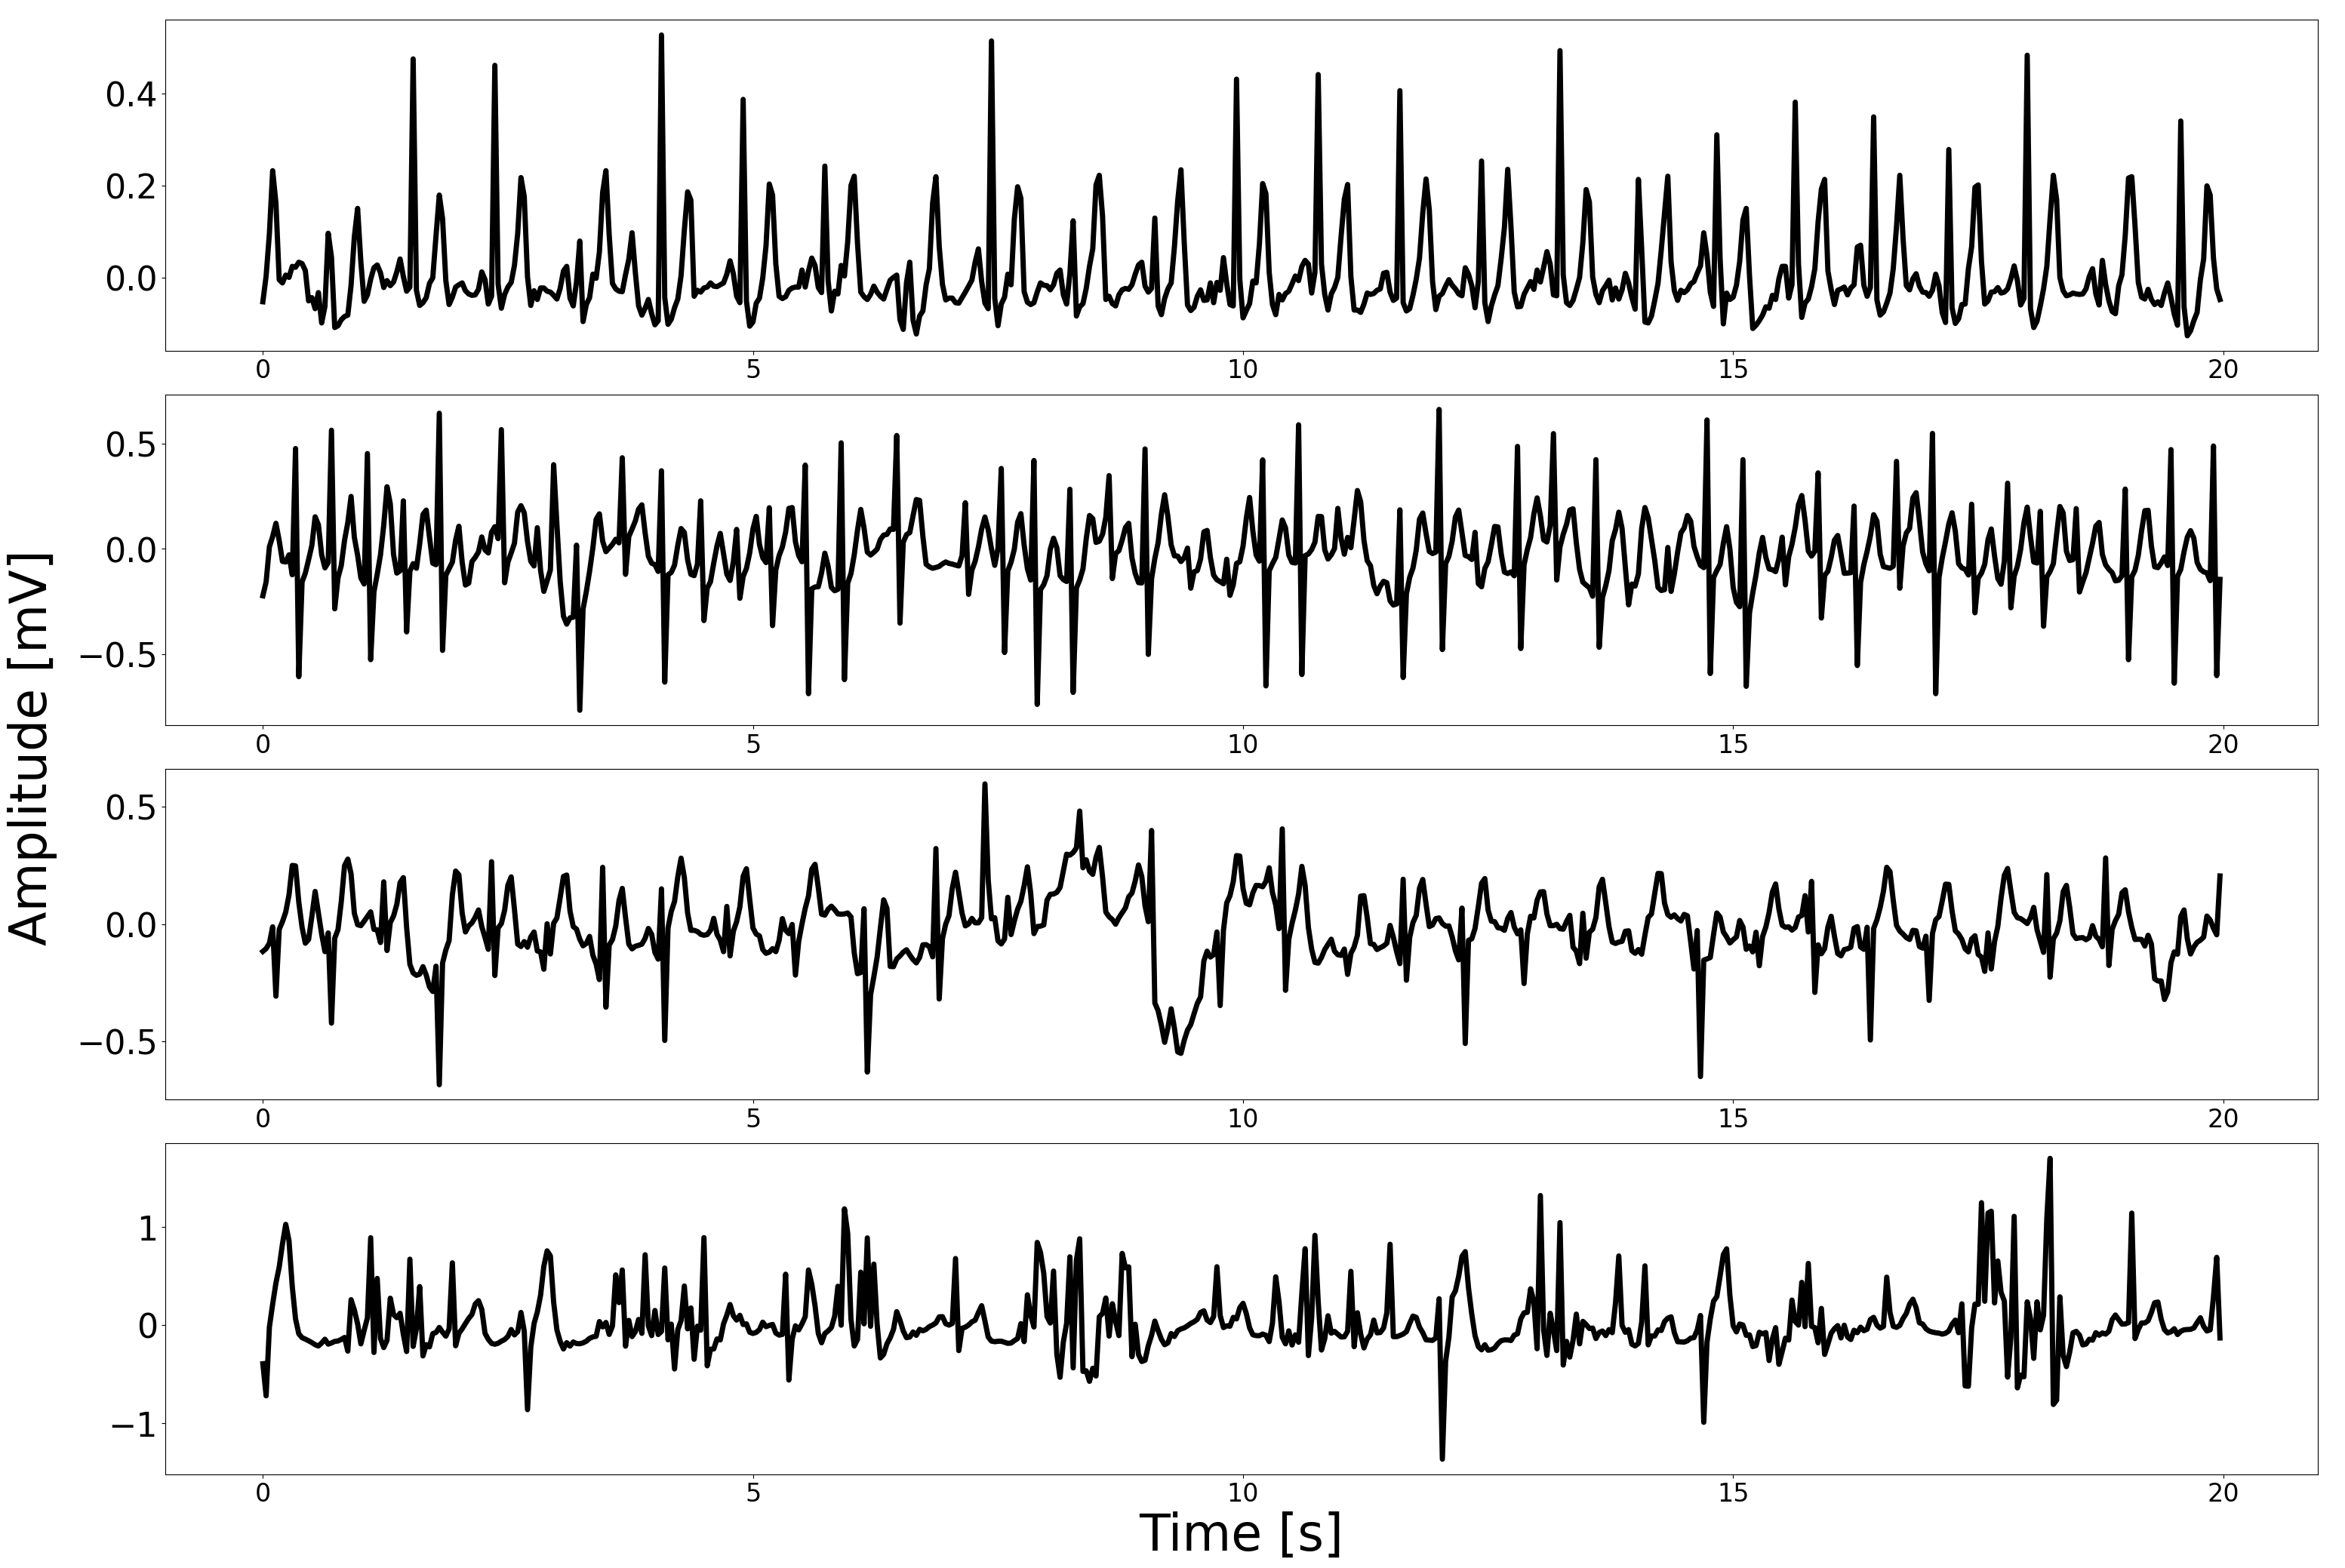

In [9]:
# Some matplotlib setting 
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
plt.rcParams['axes.labelsize'] = 48
plt.rcParams['axes.titlesize'] = 48

fig, axs = plt.subplots(4, 1)

seconds = np.arange(0, 600) / 30 
x_labels = [0, 5, 10, 15, 20]

for class_id in range(num_classes):
    ax = axs[class_id]
    #ax.set_title("Class {}".format(class_id))
    
    measurements = raw_dataset_x.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32')
    # Get a subsequence of a signal and downsample it for visualization purposes
    measurements = measurements[1000:7000:10] 
    # convert volts to millivolts
    measurements /= 1000
    ax.plot(seconds, measurements, color='k')
    ax.set_xticks(x_labels)
          
fig.tight_layout()

# Display x- and y-labels for the whole plot
ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.yaxis.set_label_coords(-0.05, 0.5)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [mV]')            
plt.show()

In [10]:
def plot_features(signal):
    ecg_cleaned = nk.ecg_clean(signal, sampling_rate=300)
    r_peaks = ecg.engzee_segmenter(ecg_cleaned, 300)['rpeaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(ecg_cleaned, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')

/tmp/ipykernel_50320/1377788874.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(range(md.shape[0]), md, 'k', label='Median HeartBeat', color='#CC4F1B')


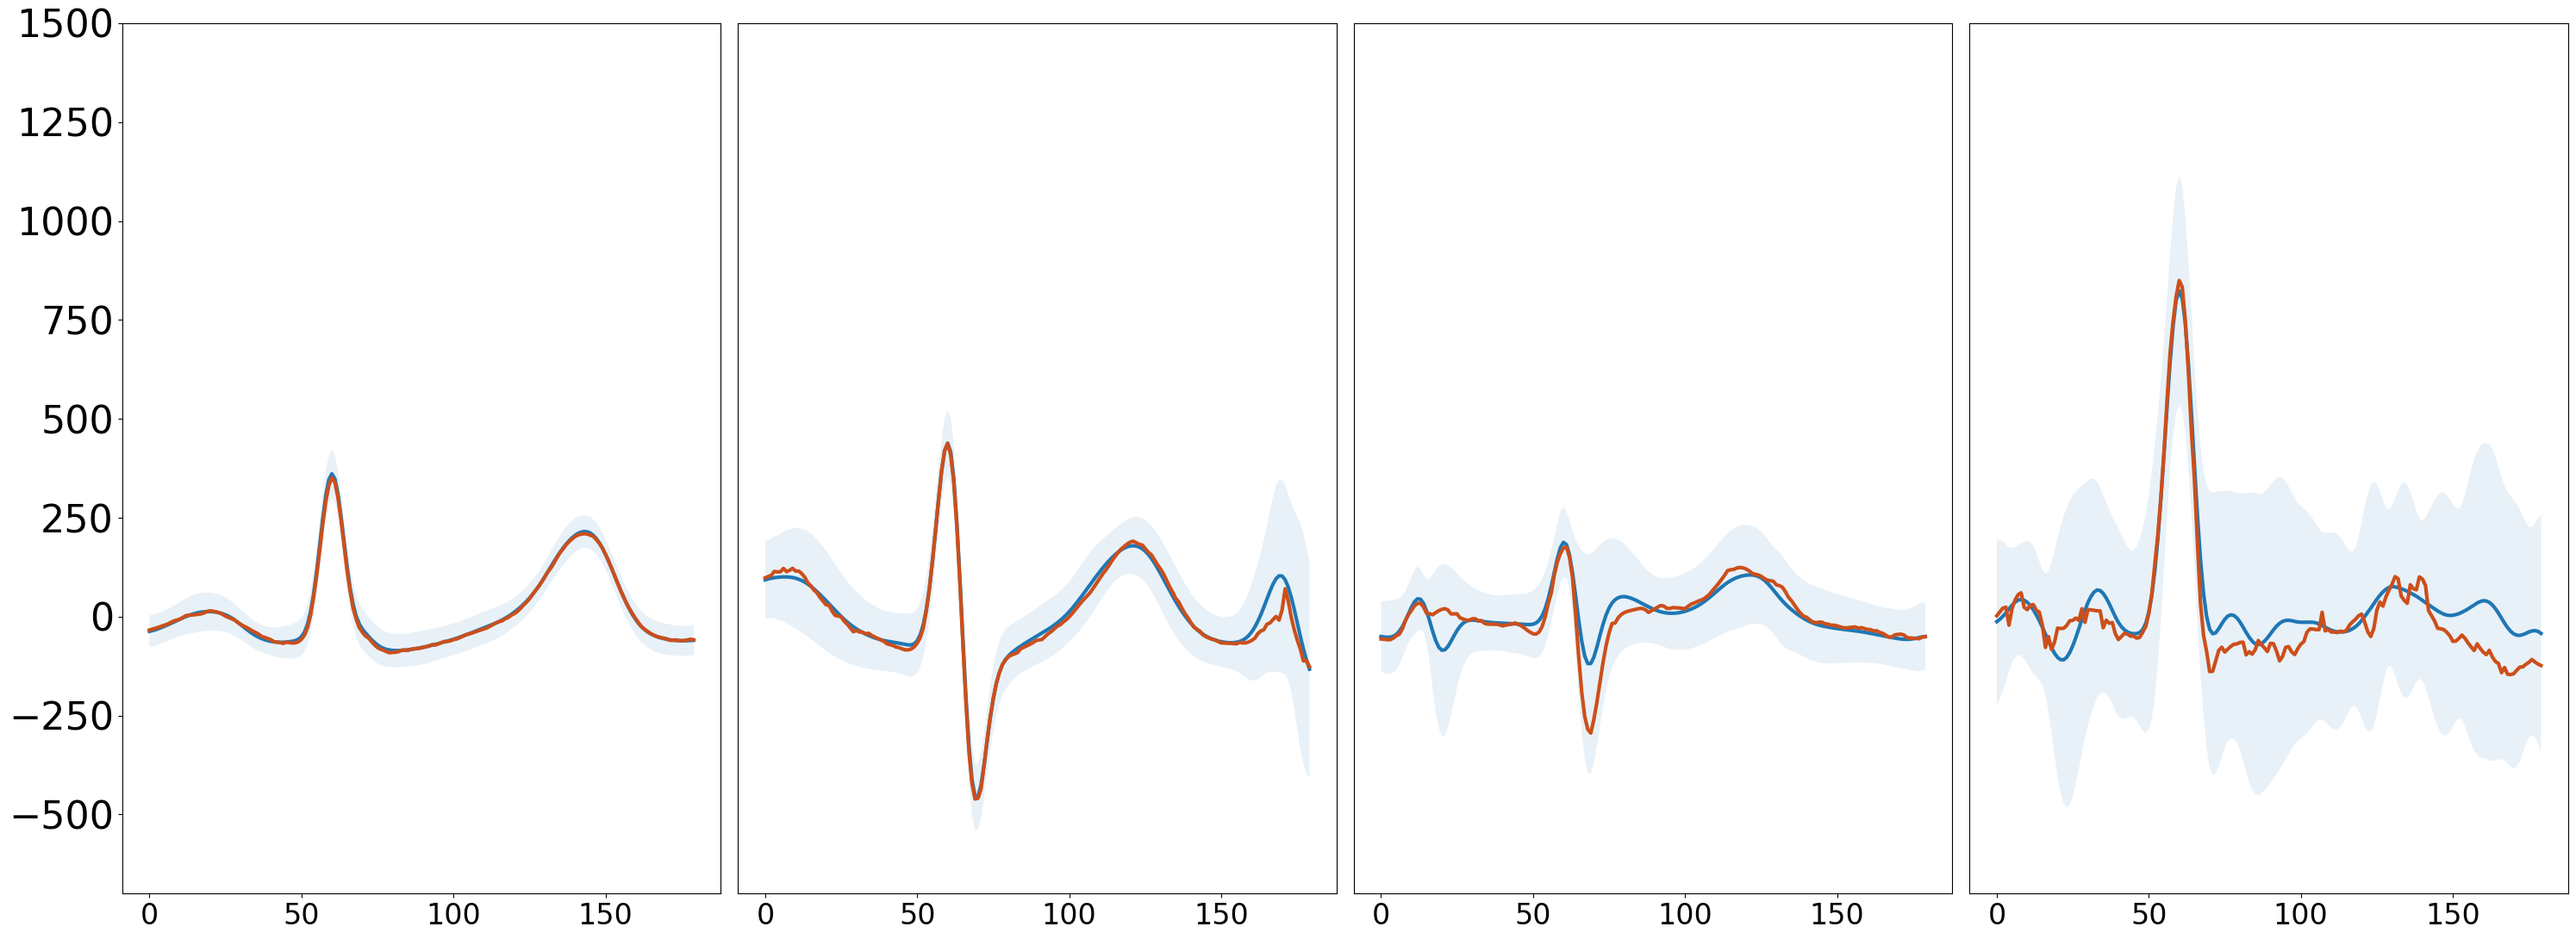

In [11]:
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(30, 11))
for class_id in range(num_classes):
    ax = plt.subplot(1, 4, class_id + 1)
    #ax.set_title("Class {}".format(class_id))
    ax.set_ylim([-700, 1500])
    if class_id:
        ax.set_yticks([])
    plot_features(raw_dataset_x.loc[sample_signal_ids[class_id]].dropna().to_numpy(dtype='float32'))

plt.tight_layout()
plt.show()

In [12]:
error_ids = []
def extrack_features(row):
    signal = row.dropna().to_numpy(dtype='float32')
    ecg_cleaned = nk.ecg_clean(signal, sampling_rate=300)
    _, r_peaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=300)
    #r_peaks = ecg.engzee_segmenter(signal, 300)['rpeaks']
    r_peaks = r_peaks['ECG_R_Peaks']
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))

        beats = ecg.extract_heartbeats(signal, r_peaks, 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0)
            median = np.median(beats, axis=0)
            std = np.std(beats,axis = 0)
        else:
            mu = np.zeros(180)
            median = np.zeros(180)
            std = np.zeros(180)
    else:
        mu = np.zeros(180)
        median = np.zeros(180)
        std = np.zeros(180)
    '''
    #########
    uniform_pattern_list = np.array([0, 1, 2, 3, 4, 6, 7, 8, 12, 14, 15, 16, 24, 28, 30, 31, 32, 48, 56, 60, 62, 63, 64, 96, 112, 120, 124, 126, 127, 128,
     129, 131, 135, 143, 159, 191, 192, 193, 195, 199, 207, 223, 224, 225, 227, 231, 239, 240, 241, 243, 247, 248, 249, 251, 252, 253, 254, 255])
    hist_u_lbp = np.zeros(59, dtype=float)
    neigh = 8
    for i in range(int(neigh/2), int(len(signal) - neigh/2)):
        pattern = np.zeros(neigh)
        ind = 0
        for n in itertools.chain(range(int(-neigh/2),0), range(1,int(neigh/2+1))):
            if signal[i] > signal[i+n]:
                pattern[ind] = 1
            ind += 1
        # Convert pattern to id-int 0-255 (for neigh =8)
        pattern_id = int("".join(str(c) for c in pattern.astype(int)), 2)

        # Convert id to uniform LBP id 0-57 (uniform LBP)  58: (non uniform LBP)
        if pattern_id in uniform_pattern_list:
            pattern_uniform_id = int(np.argwhere(uniform_pattern_list == pattern_id))
        else:
            pattern_uniform_id = 58 # Non uniforms patternsuse

        hist_u_lbp[pattern_uniform_id] += 1.0
    #print(hist_u_lbp)
    ##########


    wavel_matrix = []
    for peak in r_peaks:
        winL = peak - 90
        winR = peak + 90
        beat = signal[winL:winR]
        db1 = pywt.Wavelet('db1')
        coeffs = pywt.wavedec(beat, db1, level=3)
        wavel = coeffs[0]
        if len(wavel) == 23:
            wavel_matrix.append(wavel)

        ##########

        R_pos = int((winL + winR) / 2)
        if R_pos+90<len(signal):
            R_value = signal[R_pos]
            my_morph = np.zeros((4))
            y_values = np.zeros(4)
            x_values = np.zeros(4)
            # Obtain (max/min) values and index from the intervals
            [x_values[0], y_values[0]] = max(enumerate(beat[0:40]), key=operator.itemgetter(1))
            [x_values[1], y_values[1]] = min(enumerate(beat[75:85]), key=operator.itemgetter(1))
            [x_values[2], y_values[2]] = min(enumerate(beat[95:105]), key=operator.itemgetter(1))
            [x_values[3], y_values[3]] = max(enumerate(beat[150:180]), key=operator.itemgetter(1))

            x_values[1] = x_values[1] + 75
            x_values[2] = x_values[2] + 95
            x_values[3] = x_values[3] + 150

            # Norm data before compute distance
            x_max = max(x_values)
            y_max = max(np.append(y_values, R_value))
            x_min = min(x_values)
            y_min = min(np.append(y_values, R_value))

            R_pos = (R_pos - x_min) / (x_max - x_min)
            R_value = (R_value - y_min) / (y_max - y_min)

            for n in range(0,4):
                x_values[n] = (x_values[n] - x_min) / (x_max - x_min)
                y_values[n] = (y_values[n] - y_min) / (y_max - y_min)
                x_diff = (R_pos - x_values[n])
                y_diff = R_value - y_values[n]
                my_morph[n] =  np.linalg.norm([x_diff, y_diff])
    #print(wavel)

    #print(hos_b_matrix)
    wavel_mean = [0] * 23
    for i in range(len(wavel_matrix)):
        wavel_mean += wavel_matrix[i]
    for i in range(len(wavel_mean)):
        wavel_mean[i] = wavel_mean[i] / len(wavel_matrix)
    '''
    #print(hos_b_mean)

    try:
        if len(r_peaks) > 3:
            signal_dwt, waves_dwt = nk.ecg_delineate(ecg_cleaned,
                                    r_peaks,
                                    sampling_rate=300,
                                    method="dwt",
                                    show=False,
                                    show_type='all')
            nk_features = get_nk_features(signal, r_peaks, waves_dwt)

        else:

            nk_features = np.zeros(10)
    except Exception as e:
        error_ids.append(id)
        print(id,"error")
        nk_features = np.zeros(10)
    fft_window = np.fft.fft(ecg_cleaned)
    freq  = np.fft.fftfreq(np.array(ecg_cleaned).shape[-1], d=1/300)
    fft_ps = np.abs(fft_window)**2

    #hp_measurements = hp.process(signal, sample_rate = 300,calc_freq = True)[1]
    #print(mu.shape,wavel_mean.shape,hist_u_lbp.shape,my_morph.shape)

    total_features = pd.Series(np.concatenate((mu,median,std,nk_features)))
    return total_features

In [13]:
#x_train_sample = x_train.sample(100)

In [14]:
def apply_func(index,row):
    a = datetime.datetime.now()
    ecg_signal = row.dropna().to_numpy()
    if index in [1764,434,3506,1713,4587,5034]:
        ecg_signal = -ecg_signal
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=300)
    #     ecg_cleaned = ecg_signal

    # to try
    #max_abs = max(ecg_cleaned.min(), ecg_cleaned.max(), key=abs)
    #ecg_cleaned = ecg_cleaned / max_abs
    #     # Extract R-peaks locations
    peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=300)

    #     RR_intervals = np.diff(rpeaks['ECG_R_Peaks'])
    #     row = add_basic_info(row, RR_intervals, 'RR_intervals')

    #     R_amplitudes = np.array([ecg_cleaned[i] for i in rpeaks['ECG_R_Peaks']])
    #     row = add_basic_info(row, R_amplitudes, 'R_amplitudes')

    #     if len(rpeaks['ECG_R_Peaks']) > 3:
    #         hrv_time = nk.hrv_time(peaks, sampling_rate=300, show=False)
    #         for index, hrv_time_row in hrv_time.iterrows():
    #             for col in hrv_time.columns:
    #                 row[col] = hrv_time_row[col]

    #         hrv_freq = nk.hrv_frequency(peaks, sampling_rate=300, show=False, normalize=True)
    #         for index, hrv_freq_row in hrv_freq.iterrows():
    #             for col in hrv_freq.columns:
    #                 row[col] = hrv_freq_row[col]

    #         hrv_non = None
    #         try:
    #             hrv_non = nk.hrv_nonlinear(peaks, sampling_rate=300, show=False)
    #         except ValueError:
    #             print("Got ValueError")
    #         if hrv_non is not None:
    #             for index, hrv_non_row in hrv_non.iterrows():
    #                 for col in hrv_non.columns:
    #                     row[col] = hrv_non_row[col]

    #     out = ecg.ecg(signal=ecg_signal, sampling_rate=300., show=False)
    #     heartbeats = out['templates']
    #     max_abs = max(heartbeats.min(), heartbeats.max(), key=abs)
    #     heartbeats = heartbeats / max_abs
    #     mu = np.mean(heartbeats, axis=0)
    #     std = np.std(heartbeats, axis=0)
    #     row["max_of_std_Heartbeats"] = np.max(std)
    #     row["mean_of_std_Heartbeats"] = np.mean(std)
    #     row["min_of_std_Heartbeats"] = np.min(std)
    #     row["range_of_std_Heartbeats"] = np.max(std) - np.min(std)

    # Delineate the ECG signal
    b = datetime.datetime.now()
    #print("r_peak", (b - a).seconds)
    mu = np.zeros(180)
    median = np.zeros(180)
    std = np.zeros(180)
    if len(rpeaks['ECG_R_Peaks']) >= 2:
        # print(ecg.extract_heartbeats(signal, r_peaks, 300))

        beats = ecg.extract_heartbeats(ecg_signal, rpeaks['ECG_R_Peaks'], 300)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0)
            median = np.median(beats, axis=0)
            std = np.std(beats, axis=0)

    c = datetime.datetime.now()
    #print("extract_heartbeats", (c - b).seconds)
    nk_features = np.zeros((0,14))
    if len(rpeaks['ECG_R_Peaks']) > 3:
        try:
            signal_dwt, waves_dwt = nk.ecg_delineate(ecg_cleaned, rpeaks, show_type='all', sampling_rate=300,
                                                     method="dwt")
            for key, arr in waves_dwt.items():
                if 'Onsets' in key or 'Offsets' in key:
                    #row = add_basic_info(row, np.array(arr), key)
                    amplitudes = np.array([ecg_cleaned[i] for i in arr if not np.isnan(i)])
                    #row = add_basic_info(row, amplitudes, f"{key}_amplitudes")
            nk_features = get_nk_features(ecg_cleaned, rpeaks['ECG_R_Peaks'], waves_dwt)
        except:
            print("Got error in delineate")
    d = datetime.datetime.now()
    #print("delineate", (d - c).seconds)
    fft_window = np.fft.fft(ecg_cleaned)
    freq = np.fft.fftfreq(np.array(ecg_cleaned).shape[-1], d=1/300)
    fft_ps = np.abs(fft_window)**2
    
    #print(fft_window, freq, fft_ps)
    e = datetime.datetime.now()
    #print("fft", (e - d).seconds)
    row = row.drop(columns=[f'x{num}' for num in range(17807)])
    f = datetime.datetime.now()
    values_dict = {}
    #print("drop", (f - e).seconds)
    for i in range(180):
        values_dict[f'mu_{i}'] = mu[i]
        values_dict[f'median_{i}'] = median[i]
    for i in range(len(fft_window)):
        #values_dict[f'fft_window_{i}'] = fft_window[i]
        #values_dict[f'freq_{i}'] = freq[i]
        #values_dict[f'fft_ps_{i}'] = fft_ps[i]
        pass
    for i in range(len(nk_features)):
        values_dict[f'nk_feat_{i}'] = nk_features[i]
    
    #row.append(pd.Series(values_dict))
    g = datetime.datetime.now()
    #print("add", (g - f).seconds)
    return values_dict

In [15]:
#classify ecg
from functions import *
def classify_ecg(x_train):
    x_train_ecg = x_train.copy()
    '''
    x_train_ecg = x_train_ecg.apply(apply_func)
    '''
    new_train_dict = {}
    for index,row in x_train.iterrows():
        new_train_dict[str(index)] = apply_func(index,row)
        if len(new_train_dict) % 1000 == 0:
            print(len(new_train_dict))
        
    return pd.DataFrame.from_dict(new_train_dict,orient='index')
    
    return x_train_ecg

In [16]:
x_train = classify_ecg(x_train)

/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/

In [ ]:
x_train.to_csv('x_train_preprocess.csv')

In [ ]:
x_test = classify_ecg(x_test)

add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0
1000
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0


/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


add 0
add 0
add 0
add 0
add 0


In [ ]:
x_test.to_csv('x_test_preprocess.csv')

In [ ]:
#count nan values per column
def count_nan(df):
    for col in df.columns:
        if(df[col].isna().sum() > 0):
            print(col,df[col].isna().sum())
    
count_nan(x_train)

freq_2960 1
fft_ps_2960 1
freq_2961 1
fft_ps_2961 1
freq_2962 1
fft_ps_2962 1
freq_2963 1
fft_ps_2963 1
freq_2964 1
fft_ps_2964 1
freq_2965 1
fft_ps_2965 1
freq_2966 1
fft_ps_2966 1
freq_2967 1
fft_ps_2967 1
freq_2968 1
fft_ps_2968 1
freq_2969 1
fft_ps_2969 1
freq_2970 1
fft_ps_2970 1
freq_2971 1
fft_ps_2971 1
freq_2972 1
fft_ps_2972 1
freq_2973 1
fft_ps_2973 1
freq_2974 1
fft_ps_2974 1
freq_2975 1
fft_ps_2975 1
freq_2976 1
fft_ps_2976 1
freq_2977 1
fft_ps_2977 1
freq_2978 1
fft_ps_2978 1
freq_2979 1
fft_ps_2979 1
freq_2980 1
fft_ps_2980 1
freq_2981 1
fft_ps_2981 1
freq_2982 1
fft_ps_2982 1
freq_2983 1
fft_ps_2983 1
freq_2984 1
fft_ps_2984 1
freq_2985 1
fft_ps_2985 1
freq_2986 1
fft_ps_2986 1
freq_2987 1
fft_ps_2987 1
freq_2988 1
fft_ps_2988 1
freq_2989 1
fft_ps_2989 1
freq_2990 1
fft_ps_2990 1
freq_2991 1
fft_ps_2991 1
freq_2992 1
fft_ps_2992 1
freq_2993 1
fft_ps_2993 1
freq_2994 1
fft_ps_2994 1
freq_2995 1
fft_ps_2995 1
freq_2996 1
fft_ps_2996 1
freq_2997 1
fft_ps_2997 1
freq_2998 1


In [ ]:
x_train = x_train.fillna(0)

In [ ]:
selector = SelectKBest(score_func=f_classif, k=120)
selector.fit(np.array(x_train), np.array(y_train).squeeze())
cols = selector.get_support(indices=True)

ValueError: Found input variables with inconsistent numbers of samples: [100, 4093]

In [ ]:
x_train= x_train.iloc[:,cols]
x_test = x_test.iloc[:,cols]

In [ ]:
#scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [ ]:
from sklearn import svm

class_weights = {}
for c in range(4):
    class_weights.update({c:len(y_train) / float(np.count_nonzero(y_train == c))})


svm_model = svm.SVC( kernel='rbf', degree=3, gamma='auto',class_weight=class_weights, decision_function_shape='ovr', random_state=0)

svm_model.fit(x_train, np.ravel(y_train))

In [ ]:
y_pred = svm_model.predict(x_test)

In [ ]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
mod = GradientBoostingClassifier(n_estimators=100, random_state=0).fit(x_train, np.ravel(y_train))

In [ ]:
y_pred_gbc = mod.predict(np.array(x_test))

In [ ]:
from sklearn.metrics import f1_score
def performance(y_pred):
    varb = y_test.empty
    if not y_test.empty:
        return f1_score(y_test, y_pred, average='macro')

In [ ]:
performance(y_pred_gbc)
#0.46987225134934824

In [ ]:
performance(y_pred)
#0.5239022822832634

In [ ]:
pd.DataFrame(y_pred_gbc,columns = ['y']).to_csv('output.txt',index_label="id")